In [348]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [368]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, datasets
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [369]:
# This function is the Riegel formula for predicting race time T2 over distance D2 
# from a previous time T1 over a distance D1
def Riegel(T1_sec, D1, D2):
    T2_sec = (T1_sec) * (float(D2)/float(D1))*1.06
    return T2_sec

# convert times in the format min:sec or min:sec:millisec (e.g. 14:32 or 14:32:00) to seconds
def time_to_secs(time):
    secs = int(float(str(time)[:2])*60 + float(str(time)[3:5]))
    return secs

# convert times in the format hour:min:sec to seconds
def time_to_secs_hours(time):
    secs = int(float(str(time)[0])*60*60 + float(str(time)[2:4])*60 + float(str(time)[6:8])*60)
    return secs

In [370]:
# Read the data into a pandas dataframe

df_M = pd.read_csv('runbritain_data_2016_M_5K.csv')
print df_M.head()

   athleteid age_group     5K    10K     HM  Mar
0       5577       SEN  13:52    NaN    NaN  NaN
1      19569       U23  14:03  29:30    NaN  NaN
2      17296       SEN  14:04  29:55    NaN  NaN
3      12131       SEN  14:06    NaN    NaN  NaN
4      47493       SEN  14:06  29:43  65:24  NaN


In [371]:
###### This needs improving - do using pandas, not converting to lists ######

# Plotting using only athletes who have times for all 4 distances (910 athletes)

# Create lists from the pandas dataframe, one for each column, for the entries that have times for all 4 events.
# Also convert the times into seconds
data_5K_M_full = []
data_10K_M_full = []
data_HM_M_full = []
data_Mar_M_full = []

for i in range(0, len(df_M['5K'])):
    if str(df_M['10K'][i]) != 'nan' and str(df_M['HM'][i]) != 'nan' and str(df_M['Mar'][i]) != 'nan':
        data_5K_M_full.append(time_to_secs(df_M['5K'][i]))
        data_10K_M_full.append(time_to_secs(df_M['10K'][i]))
        data_Mar_M_full.append(time_to_secs_hours(df_M['Mar'][i]))
        if int(str(df_M['HM'][i])[0]) > 3:
            data_HM_M_full.append(time_to_secs(df_M['HM'][i]))
        elif int(str(df_M['HM'][i])[0]) < 4:
            data_HM_M_full.append(time_to_secs_hours(df_M['HM'][i]))

# put the lists for each event into a list of lists
data_M_full = np.array([data_5K_M_full, data_10K_M_full, data_HM_M_full, data_Mar_M_full])

## Transpose the data and put it into a pandas dataframe with column headings
data_M_full_T = np.transpose(data_M_full)
print data_M_full_T.shape
labels = ["5K", "10K", "HM", "Mar"]
df_data_M_full = pd.DataFrame(data_M_full_T, columns=labels)
print df_data_M_full.head()

(910, 4)
    5K   10K    HM   Mar
0  846  1794  3815  8400
1  875  1853  3950  8820
2  878  1856  4077  9000
3  883  1798  3986  9060
4  887  1874  4054  9180


In [372]:
# Use the Riegel formula to predict the time of event 2 for each point in event 1 
# for all combinations of events

# Calculate a measure of how close the Reigel prediction is to the actual data using the root mean squared error

distances = [5, 10, 21.24334, 42.16481]
prediction = [[[]]*len(distances) for i in range(0, len(distances))]
r_squared = [[[]]*len(distances) for i in range(0, len(distances))]
rms = [[[]]*len(distances) for i in range(0, len(distances))]
for i in range(0, len(distances)):
    for j in range(0, len(distances)):
        prediction[i][j] = [Riegel(data_M_full[i][k], distances[i], distances[j]) for k in range(0, len(data_M_full[0]))]
#        slope, intercept, r_value, p_value, std_err = stats.linregress(prediction[i][j][:4], times[j][:4])
#        r_squared[i][j] = str(round(r_value, 2))
        rms_error = sqrt(mean_squared_error(data_M_full[j], prediction[i][j]))
        rms[i][j] = str(int(round(rms_error)))

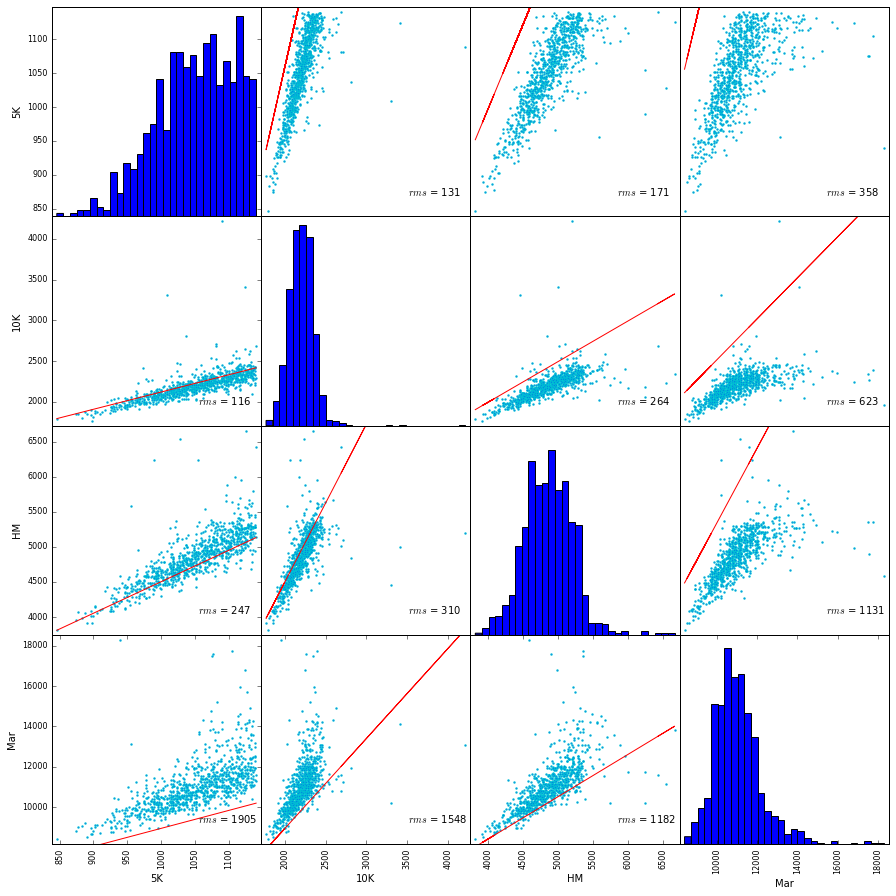

In [373]:
# Plot the data using a scatter matrix

axes = pd.scatter_matrix(df_data_M_full, figsize=(15, 15),
                      hist_kwds={'bins': 30}, s=10, alpha=.8, color = 'darkturquoise')

# Plot the Reigel prediction and the rms errors
for i in range(0, 4):
    for j in range(0, 4):
        if i != j:
            axes[j, i].plot(data_M_full[i], prediction[i][j], color = 'r')
#            axes[j,i].annotate("$R^2$ = " + r_squared[i][j], xy=(0.7, 0.1), xycoords="axes fraction")
            axes[j,i].annotate("$rms$ = " + rms[i][j], xy=(0.7, 0.1), xycoords="axes fraction")

In [374]:
##### Machine learning using one feature

# Use the same data to calculate each event from each other event using Machince learning 
# to find the best fit. The Ridge algorithm for regularised linear regression is used, but 
# alpha is set to zero as regularisation doesn't make a difference

ML_prediction = [[[]]*len(distances) for i in range(0, len(distances))] 
#r_squared_ML = [[[]]*len(distances) for i in range(0, len(distances))]
rms_ML = [[[]]*len(distances) for i in range(0, len(distances))]
for i in range(0, len(distances)):
     for j in range(0, len(distances)):
            X = data_M_full[i].reshape(-1, 1)
            y = data_M_full[j].reshape(-1, 1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
            ridge = Ridge(alpha=0).fit(X_train, y_train)
            ML_prediction[i][j] = ridge.predict(X)
#            slope, intercept, r_value_ML, p_value, std_err = stats.linregress(np.array(ML_prediction[i][j]).reshape(-1)[:4], np.array(times[j])[:4])
#            r_squared_ML[i][j] = str(round(r_value_ML, 2))
            rms_error_ML = sqrt(mean_squared_error(data_M_full[j], np.array(ML_prediction[i][j]).reshape(-1)))
            rms_ML[i][j] = str(int(round(rms_error_ML)))

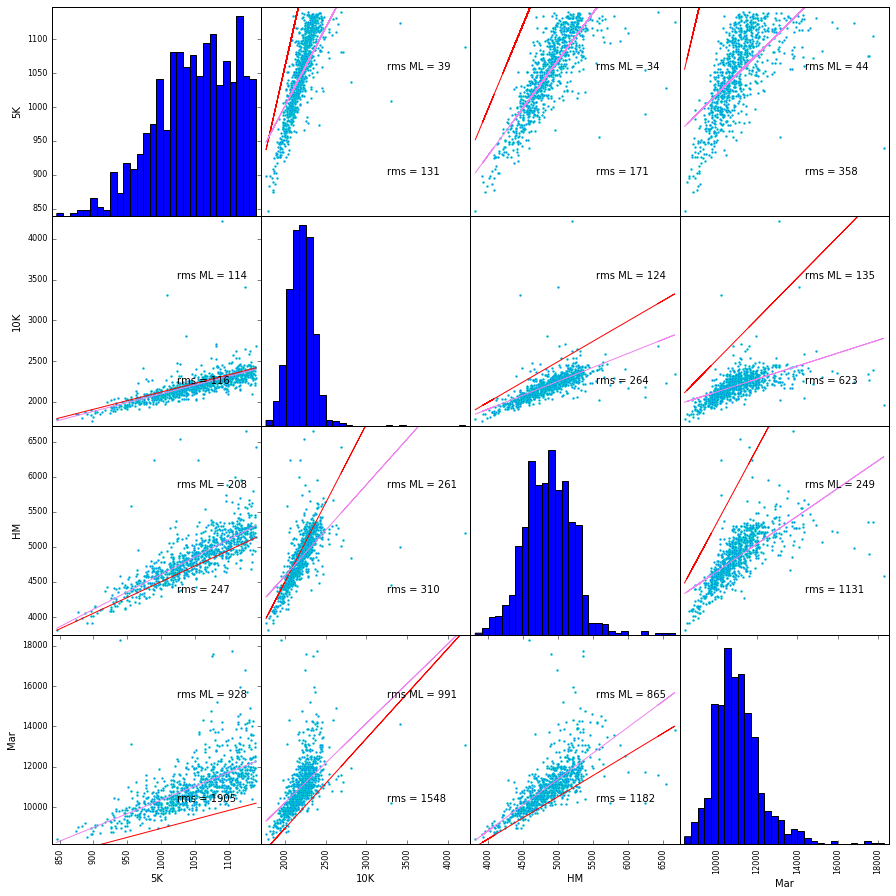

In [375]:
# Plot the data as before
axes = pd.scatter_matrix(df_data_M_full, figsize=(15, 15),
                      hist_kwds={'bins': 30}, s=10, alpha=.8, color = 'darkturquoise')

# Plot the Reigel predictions and rms as before and add the machine learning predicitons and rms errors.
for i in range(0, 4):
    for j in range(0, 4):
        if i != j:
            axes[j, i].plot(data_M_full[i], prediction[i][j], color = 'r')
            axes[j, i].plot(data_M_full[i], ML_prediction[i][j], color = 'violet')
#            axes[j,i].annotate("$R^2$ = " + r_squared[i][j], xy=(0.7, 0.1), xycoords="axes fraction")
#            axes[j,i].annotate("$R^2$ = " + r_squared_ML[i][j], xy=(0.7, 0.7), xycoords="axes fraction")
            axes[j,i].annotate("rms = " + rms[i][j], xy=(0.6, 0.2), xycoords="axes fraction")
            axes[j,i].annotate("rms ML = " + rms_ML[i][j], xy=(0.6, 0.7), xycoords="axes fraction")


In [393]:
##### Machine learning using one feature

# Use the same data to calculate each event from each other event using Machince learning 
# to find the best fit. The Ridge algorithm for regularised linear regression is used, but 
# alpha is set to zero as regularisation doesn't make a difference
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
RANSAC_prediction = [[[]]*len(distances) for i in range(0, len(distances))] 
#r_squared_ML = [[[]]*len(distances) for i in range(0, len(distances))]
rms_RANSAC = [[[]]*len(distances) for i in range(0, len(distances))]
for i in range(0, len(distances)):
     for j in range(0, len(distances)):
            X = data_M_full[i].reshape(-1, 1)
            y = data_M_full[j].reshape(-1, 1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
            model_ransac.fit(X_train, y_train)
            RANSAC_prediction[i][j] = model_ransac.predict(X)
#            slope, intercept, r_value_ML, p_value, std_err = stats.linregress(np.array(ML_prediction[i][j]).reshape(-1)[:4], np.array(times[j])[:4])
#            r_squared_ML[i][j] = str(round(r_value_ML, 2))
            rms_error_RANSAC = sqrt(mean_squared_error(data_M_full[j], np.array(RANSAC_prediction[i][j]).reshape(-1)))
            rms_RANSAC[i][j] = str(int(round(rms_error_RANSAC)))

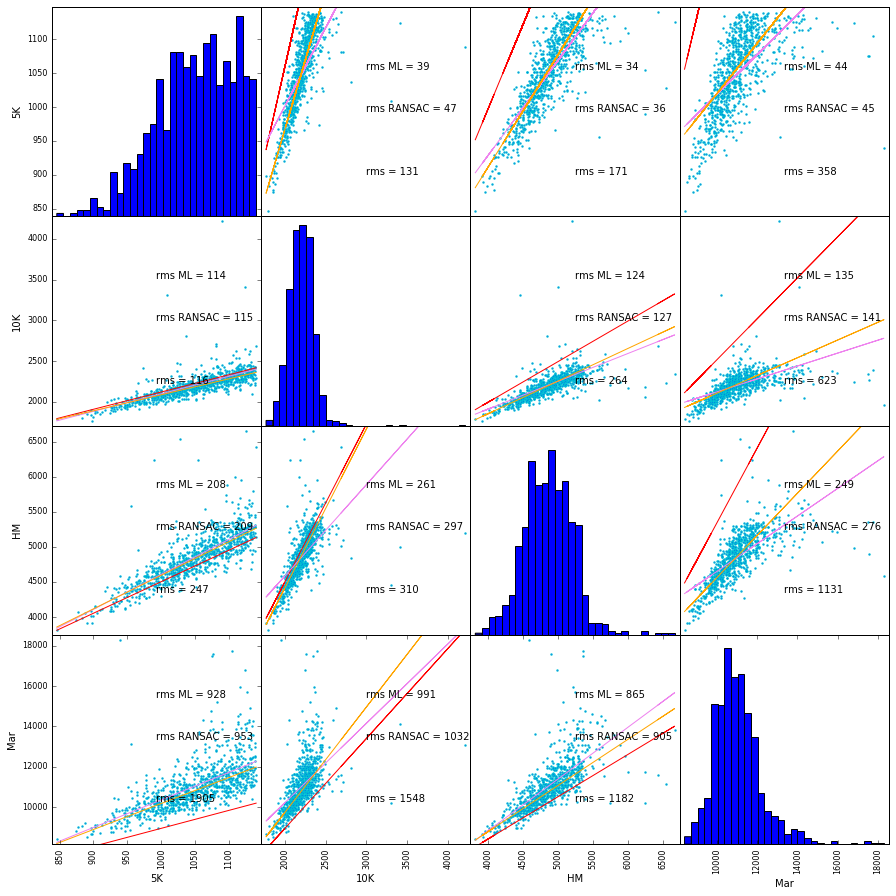

In [396]:
# Plot the data as before
axes = pd.scatter_matrix(df_data_M_full, figsize=(15, 15),
                      hist_kwds={'bins': 30}, s=10, alpha=.8, color = 'darkturquoise')

# Plot the Reigel predictions and rms as before and add the machine learning predicitons and rms errors.
for i in range(0, 4):
    for j in range(0, 4):
        if i != j:
            axes[j, i].plot(data_M_full[i], prediction[i][j], color = 'r')
            axes[j, i].plot(data_M_full[i], ML_prediction[i][j], color = 'violet')
            axes[j, i].plot(data_M_full[i], RANSAC_prediction[i][j], color = 'orange')
#            axes[j,i].annotate("$R^2$ = " + r_squared[i][j], xy=(0.7, 0.1), xycoords="axes fraction")
#            axes[j,i].annotate("$R^2$ = " + r_squared_ML[i][j], xy=(0.7, 0.7), xycoords="axes fraction")
            axes[j,i].annotate("rms = " + rms[i][j], xy=(0.5, 0.2), xycoords="axes fraction")
            axes[j,i].annotate("rms ML = " + rms_ML[i][j], xy=(0.5, 0.7), xycoords="axes fraction")
            axes[j,i].annotate("rms RANSAC = " + rms_RANSAC[i][j], xy=(0.5, 0.5), xycoords="axes fraction")


(600.0, 1150)

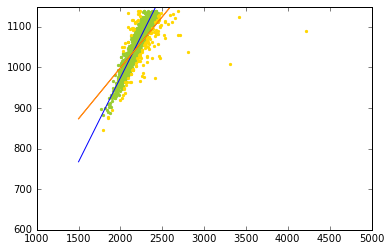

In [392]:
#### Redo fitting but use RANSAC to deal with the outliers

X = data_M_full[1].reshape(-1, 1)
y = data_M_full[0].reshape(-1, 1)

model = linear_model.LinearRegression()
model.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

ridge = Ridge(alpha=0).fit(X, y)

# # Predict data of estimated models
line_X = np.arange(1500, 4500)
line_y = model.predict(line_X.reshape(-1, 1))
line_y_ridge = ridge.predict(line_X.reshape(-1, 1))
line_y_ransac = model_ransac.predict(line_X.reshape(-1, 1))

# line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

# # Compare estimated coefficients
# print("Estimated coefficients (true, normal, RANSAC):")
# print(coef, model.coef_, model_ransac.estimator_.coef_)

# lw = 2
#plt.scatter(X, y, color='yellowgreen')
plt.plot(line_X, line_y_ransac, color='b')
plt.plot(line_X, line_y, color='r')
plt.plot(line_X, line_y_ridge, color='orange')

plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.ylim(ymax = 1150)
# plt.plot(line_X, line_y, color='navy', linestyle='-', linewidth=lw,
#          label='Linear regressor')
# plt.plot(line_X, line_y_ransac, color='cornflowerblue', linestyle='-',
#          linewidth=lw, label='RANSAC regressor')
# plt.legend(loc='lower right')
# plt.show()

In [231]:
#### Machine Learning using all events

X = df_data_M_full[['5K', 'HM', 'Mar']]
y = df_data_M_full['10K']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
ridge = Ridge(alpha=1).fit(X_train, y_train)
print("training set score: %.2f" % ridge.score(X_train, y_train)) 
print("test set score: %.2f" % ridge.score(X_test, y_test))

slope, intercept, r_value, p_value, std_err = stats.linregress(ridge.predict(X_test), np.array(y_test.tolist()))
print "r-squared:", r_value**2

rms_error_ML_all = sqrt(mean_squared_error(ridge.predict(X_test), np.array(y_test.tolist())))
print str(int(round(rms_error_ML_all)))

print ridge.predict(X_test)[0:10]
#print np.array(y_test[:10].tolist())

example_times = np.array([25*60, 100*60, 4*60*60]).reshape(1, -1)
#print ridge.predict(example_times)/60.0

training set score: 0.53
test set score: 0.74
r-squared: 0.762952717497
67
[ 2127.87886085  2317.41472522  2143.92326448  2281.75781257  2077.45226179
  2162.1363534   1973.48464092  2326.85632208  2057.94109029  1903.59319654]
